In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [18]:
df = pd.read_csv('E:/Users/virtual_environments/crypto_price_predictor/data/eth_data.csv')
coin = 'ETH'
for i in range(df.shape[0]):
    df['Date'].iloc[i] = int(pd.Timestamp(pd.to_datetime(df['Date'].iloc[i],format= '%b %d, %Y' )).timestamp())
df.head()

,Date,Close,Open,High,Low,Vol.,Change %
0,1679875200,1764.53,1773.91,1780.06,1747.56,383.13K,-0.54%
1,1679788800,1774.06,1742.32,1796.77,1739.39,371.97K,1.82%
2,1679702400,1742.34,1749.28,1761.66,1714.43,368.84K,-0.40%
3,1679616000,1749.26,1813.62,1818.53,1728.69,602.30K,-3.57%
4,1679529600,1814.08,1734.32,1852.48,1729.38,767.73K,4.59%


In [19]:
df.Date = pd.to_datetime(df.Date, unit='s')

df.index = df.Date
df = df.resample('D').mean()

df_month = df.resample('M').mean()


In [20]:

df_month['close_box'], lmbda = stats.boxcox(df_month.Close)

In [21]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.close_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12), enforce_stationarity=False).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
40  (2, 0, 2, 0)  109.646714
22  (1, 0, 2, 0)  109.793706
10  (0, 1, 2, 0)  110.244113
28  (1, 1, 2, 0)  110.404623
41  (2, 0, 2, 1)  110.928707
                                     SARIMAX Results                                      
Dep. Variable:                          close_box   No. Observations:                   85
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 -49.823
Date:                            Fri, 31 Mar 2023   AIC                            109.647
Time:                                    20:07:53   BIC                            118.790
Sample:                                03-31-2016   HQIC                           113.072
                                     - 03-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

In [23]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [24]:
import requests

x = requests.get('http://localhost:8000/api/analyzeTweets/')
x = x.json()

In [25]:
from datetime import datetime
y = x['data'][coin]
factor = y['sum']/y['cnt']

# factor

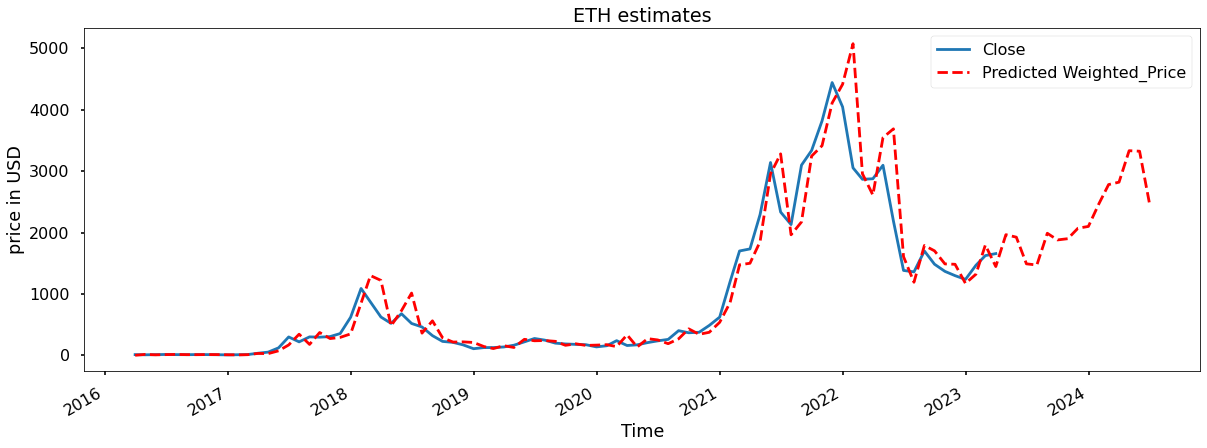

In [26]:
# Prediction
from datetime import datetime
df_month2 = df_month[['Close']]
date_list = [datetime(2023, 3, 31), datetime(2023, 4, 30), datetime(2023, 5, 31), datetime(2023, 6, 30), 
             datetime(2023, 7, 31), datetime(2023, 8, 31), datetime(2023, 9, 30), datetime(2023, 10, 31),
             datetime(2023, 11, 30), datetime(2023, 12, 31), datetime(2024, 1, 31), datetime(2024, 2, 29),
             datetime(2024, 3, 31),datetime(2024, 4, 30),datetime(2024, 5, 31),datetime(2024, 6, 30)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=400), lmbda)


mask = (df_month2.index > datetime.today().strftime('%Y-%m-%d'))
df_month2.loc[mask]['forecast'] *= (factor*0.05)


plt.figure(figsize=(20,7))
df_month2.Close.plot()

df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title(f'{coin} estimates')
plt.ylabel('price in USD')
plt.xlabel('Time')
# plt.show()
plt.savefig(f'E:/Users/virtual_environments/crypto_price_predictor/frontend/src/output/{coin}_plot.png')

In [27]:
df_month2 = df_month2[['Close', 'forecast']]
df_month2.dropna(inplace=True)

In [28]:
from sklearn import metrics

np.sqrt(metrics.mean_squared_error(df_month2.Close, df_month2.forecast))

355.07535522634885